In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('D:\\Downloads\\PYTORCH_NOTEBOOKS\\PYTORCH_NOTEBOOKS\Data\\TimeSeriesData\\Alcohol_Sales.csv',index_col=0,parse_dates=True)
df.head()
df=df.dropna()

In [3]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

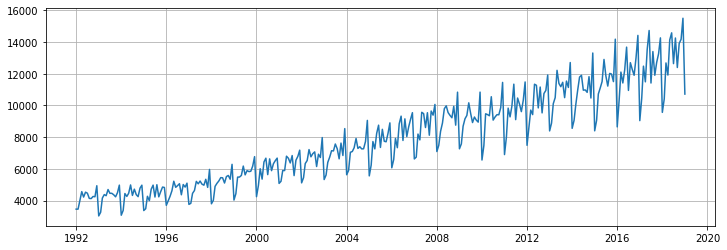

In [4]:
plt.figure(figsize=(12,4))
plt.plot(df['S4248SM144NCEN'])
plt.grid()

In [5]:
y=df['S4248SM144NCEN'].values.astype('float')

In [6]:
test_size=24
train_set=y[:-test_size]
test_set=y[-test_size:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))

In [8]:
scaler.fit(train_set.reshape(-1,1))
train_dat_scale=scaler.transform(train_set.reshape(-1,1))
test_dat_scale=scaler.transform(test_set.reshape(-1,1))

In [9]:
def create_dat_tuples(seq,ws):
    dat_list=[]
    for i in range(len(seq)-ws):
        dat_list.append((seq[i:i+ws],seq[i+ws:i+ws+1]))
    return(dat_list)
train_tensor=torch.FloatTensor(train_dat_scale).view(-1)
dat_tuples=create_dat_tuples(train_tensor,12)

In [10]:
class lstm_mod(nn.Module):
    def __init__(self,in_size=1,out_size=1,hidden_size=50):
        super(lstm_mod,self).__init__()
        self.hid_size=hidden_size
        self.lstm=nn.LSTM(in_size,hidden_size)
        self.lin=nn.Linear(hidden_size,out_size)
        self.hidden=(torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    def forward(self,X):
        lstm_out,self.hidden=self.lstm(X.view(len(X),1,-1),self.hidden)
        pred=self.lin(lstm_out)
        return(pred[-1])
torch.manual_seed(42)
model=lstm_mod()
model

lstm_mod(
  (lstm): LSTM(1, 50)
  (lin): Linear(in_features=50, out_features=1, bias=True)
)

In [11]:
crit=nn.MSELoss()
opt=torch.optim.Adam(model.parameters())

In [12]:
def train_single_epoch(dat,mod,crit,opt,disp_int):
    batch_loss_tracker=[]
    for b,ex in enumerate(dat):
        opt.zero_grad()
        mod.hidden=(torch.zeros(1,1,mod.hid_size),torch.zeros(1,1,mod.hid_size))
        pred=mod.forward(ex[0])
        loss=crit(pred,ex[1])
        batch_loss_tracker.append(loss.item())
        loss.backward()
        opt.step()
        if(b% disp_int==0):
            print(f'Batch:{b} Loss:{batch_loss_tracker[b]:0.4f}')
        
    return(mod,batch_loss_tracker)
def train_model(num_epochs,dat,mod,crit,opt,disp_int=20):
    epoch_loss_tracker=[]
    for i in range(num_epochs):
        print(f'_________________Epoch:{i}__________________')
        mod,batch_loss_tracker=train_single_epoch(dat,mod,crit,opt,disp_int=disp_int)
        epoch_loss_tracker.extend(batch_loss_tracker)
    return(mod,epoch_loss_tracker)

trained_mod,epoch_loss_tracker=train_model(50,dat_tuples,model,crit,opt,disp_int=50)


_________________Epoch:0__________________
Batch:0 Loss:0.7606


c:\Users\Sushanth\Anaconda3\envs\venv_torch\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch:50 Loss:0.0102
Batch:100 Loss:0.0178
Batch:150 Loss:0.0010
Batch:200 Loss:0.0031
Batch:250 Loss:0.0002
_________________Epoch:1__________________
Batch:0 Loss:1.9694
Batch:50 Loss:0.0031
Batch:100 Loss:0.0216
Batch:150 Loss:0.0008
Batch:200 Loss:0.0262
Batch:250 Loss:0.0109
_________________Epoch:2__________________
Batch:0 Loss:0.9003
Batch:50 Loss:0.0057
Batch:100 Loss:0.0188
Batch:150 Loss:0.0009
Batch:200 Loss:0.0001
Batch:250 Loss:0.0002
_________________Epoch:3__________________
Batch:0 Loss:0.3919
Batch:50 Loss:0.0040
Batch:100 Loss:0.0162
Batch:150 Loss:0.0033
Batch:200 Loss:0.0009
Batch:250 Loss:0.0000
_________________Epoch:4__________________
Batch:0 Loss:0.2213
Batch:50 Loss:0.0025
Batch:100 Loss:0.0156
Batch:150 Loss:0.0034
Batch:200 Loss:0.0010
Batch:250 Loss:0.0003
_________________Epoch:5__________________
Batch:0 Loss:0.2152
Batch:50 Loss:0.0023
Batch:100 Loss:0.0160
Batch:150 Loss:0.0034
Batch:200 Loss:0.0021
Batch:250 Loss:0.0003
_________________Epoch:6_______

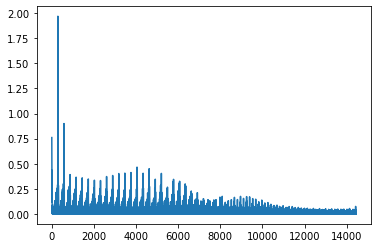

In [13]:
plt.plot(epoch_loss_tracker)

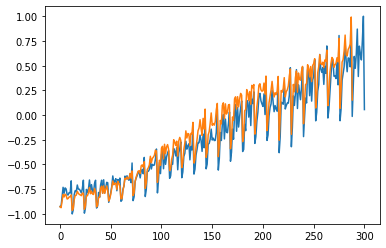

In [16]:
plt.plot(train_dat_scale)
preds_train=[]
for i in range(len(dat_tuples)):
    model.hidden=(torch.zeros(1,1,model.hid_size),torch.zeros(1,1,model.hid_size))
    preds_train.append(model.forward(dat_tuples[i][0]).detach().numpy())
plt.plot(np.squeeze(preds_train))

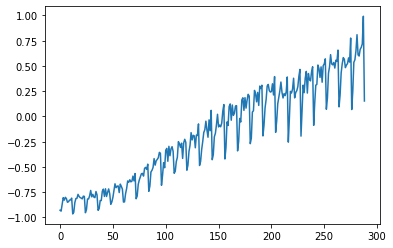